In [1]:
""""
Figaro times collection times script. 
"""
import numpy as np
import pandas as pd
import os
from openpyxl import load_workbook, Workbook
from openpyxl.utils.cell import get_column_letter

perf_path_init = r"/local/scratch/Figaro/figaro-code"
#exp_names = ["figaro", "mkl"]
exp_names = ["figaro"]
exp_paths = {"figaro": r"comparisons/performance/figaro_thin_diag", "mkl": r"comparisons/performance/python/mkl"}
db_names = ["DBRetailer", "DBFavorita", "DBYelp"]
figaro_threads = [1, 2, 4, 8, 16, 24, 32, 48]
#figaro_threads = [48]
thread_nums_exp = {"mkl": [48], "figaro": figaro_threads}

join_orders = {"DBFavorita": ["HolidaysRoot", "ItemsRoot", "OilRoot", "SalesRoot", "StoresRoot", "TransactionsRoot"],
              "DBYelp": ["BusinessRoot", "CategoryRoot", "CheckinRoot", "HoursRoot", "ReviewRoot", "UserRoot"], 
              "DBRetailer": ["CensusRoot", "InventoryRoot", "ItemRoot", "LocationRoot", "WeatherRoot"]}

start_per = 10
end_per = 100
per_inc = 10

num_measurement = 5

xlsx_name = "time.xlsx"

df_measurement_exp_dbs = {}
for exp_name in exp_names: 
    exp_path = exp_paths[exp_name]
    perf_path = os.path.join(perf_path_init, exp_path)

    for db_name in db_names:
        gather_times_path = os.path.join(perf_path, db_name + xlsx_name)
        print(gather_times_path)
        out_workbook = Workbook()
        out_workbook.remove(out_workbook.active)
        out_sheet = out_workbook.create_sheet("Times")
        df_measurement = pd.DataFrame(columns=join_orders[db_name])
        
        for join_idx, join_order in enumerate(join_orders[db_name]):
            for thread_idx, thread_num in enumerate(thread_nums_exp[exp_name]):
                for db_idx, percent in enumerate(range(start_per, end_per + 1, per_inc)): 
                    db_name_full = "{} {} {}".format(db_name, join_order, thread_num)
                    path_xlsx = os.path.join(perf_path, db_name, join_order+str(thread_num), xlsx_name)
                    if os.path.isfile(path_xlsx):
                        print("PATH", path_xlsx)
                        workbook = load_workbook(filename=path_xlsx, data_only=True)
                        sheet = workbook.active
                        row_count = sheet.max_row
                        col_idx = join_idx * thread_nums_exp[exp_name].__len__() + thread_idx + 1
                        col_letter = get_column_letter(col_idx)
                        
                        out_sheet.cell(row=1, column=col_idx).value = db_name_full
                        
                        start_row_idx = 2
                        np_measures = np.zeros(num_measurement)
                        for row_idx_dst in range(start_row_idx, start_row_idx + num_measurement):
                            offset_idx = row_idx_dst - start_row_idx
                            row_idx_src = row_count - num_measurement  + offset_idx
                            val = sheet.cell(row=row_idx_src, column=2).value
                            np_measures[offset_idx] = float(val)
                            #print(idx_shift, db_idx)
                            out_sheet.cell(row=row_idx_dst, column=col_idx).value = val
                        
                        out_sheet.cell(row=start_row_idx + num_measurement, column=col_idx).value = '=AVERAGE({}{}:{}{})'.format(col_letter, start_row_idx + 1, 
                                col_letter,6)
                        time_avg = np.mean(np_measures[1:])
                    else:
                        time_avg = float("inf")
                    df_measurement.at[thread_num, join_order] = time_avg
                
        out_workbook.save(gather_times_path)
        df_measurement_exp_dbs[(exp_name, db_name)] = df_measurement.astype(np.float64)





/local/scratch/Figaro/figaro-code/comparisons/performance/figaro_thin_diag/DBRetailertime.xlsx
PATH /local/scratch/Figaro/figaro-code/comparisons/performance/figaro_thin_diag/DBRetailer/CensusRoot1/time.xlsx
PATH /local/scratch/Figaro/figaro-code/comparisons/performance/figaro_thin_diag/DBRetailer/CensusRoot1/time.xlsx
PATH /local/scratch/Figaro/figaro-code/comparisons/performance/figaro_thin_diag/DBRetailer/CensusRoot1/time.xlsx
PATH /local/scratch/Figaro/figaro-code/comparisons/performance/figaro_thin_diag/DBRetailer/CensusRoot1/time.xlsx
PATH /local/scratch/Figaro/figaro-code/comparisons/performance/figaro_thin_diag/DBRetailer/CensusRoot1/time.xlsx
PATH /local/scratch/Figaro/figaro-code/comparisons/performance/figaro_thin_diag/DBRetailer/CensusRoot1/time.xlsx
PATH /local/scratch/Figaro/figaro-code/comparisons/performance/figaro_thin_diag/DBRetailer/CensusRoot1/time.xlsx
PATH /local/scratch/Figaro/figaro-code/comparisons/performance/figaro_thin_diag/DBRetailer/CensusRoot1/time.xlsx
P

In [2]:
t = df_measurement_exp_dbs[("figaro", "DBFavorita")]
min_idx_cols = t.idxmin(axis="columns")

print(min_idx_cols[thread_nums_exp["figaro"][-1]])


OilRoot


In [3]:
import csv

exp_name = "figaro"
exp_dat_name = "exp2cores.dat"
exp_dat_names = ["#cores", "Retailer", "Favorita", "Yelp"]
dbs_results = []
for db_name in db_names:
    df_measurement = df_measurement_exp_dbs[(exp_name, db_name)]
    print(df_measurement)
    min_idx_cols = df_measurement.idxmin(axis="columns")
    max_num_threads = thread_nums_exp[exp_name][-1]
    min_join_order = min_idx_cols[max_num_threads]
    dbs_results.append(df_measurement[min_join_order])
    print(df_measurement[min_join_order])
df_db_results = pd.concat(dbs_results, axis=1)
df_db_results = df_db_results.reset_index().rename(columns={df_db_results.index.name:'index'})
df_db_results.columns = exp_dat_names
df_db_results.to_csv(exp_dat_name, float_format='%.2f', sep='\t', index=False, quoting=csv.QUOTE_NONE,  escapechar=" ")



    CensusRoot  InventoryRoot    ItemRoot  LocationRoot  WeatherRoot
1    83.368959     272.833564  191.442576     83.761260   153.258489
2          inf            inf         inf     51.142622          inf
4          inf            inf         inf     27.830627          inf
8          inf            inf         inf     15.729093          inf
16         inf            inf         inf     12.233208          inf
24         inf            inf         inf     11.965932          inf
32         inf            inf         inf     11.115408          inf
48    9.370660      60.580356   24.424382      8.975125    18.268405
1     83.761260
2     51.142622
4     27.830627
8     15.729093
16    12.233208
24    11.965932
32    11.115408
48     8.975125
Name: LocationRoot, dtype: float64
    HolidaysRoot  ItemsRoot    OilRoot  SalesRoot  StoresRoot  \
1            inf        inf  53.183760        inf         inf   
2            inf        inf  37.920612        inf         inf   
4            inf     

    CensusRoot  InventoryRoot    ItemRoot  LocationRoot  WeatherRoot
1    83.368959     272.833564  191.442576     83.761260   153.258489
2          inf            inf         inf     51.142622          inf
4          inf            inf         inf     27.830627          inf
8          inf            inf         inf     15.729093          inf
16         inf            inf         inf     12.233208          inf
24         inf            inf         inf     11.965932          inf
32         inf            inf         inf     11.115408          inf
48    9.370660      60.580356   24.424382      8.975125    18.268405
LocationRoot
    HolidaysRoot  ItemsRoot    OilRoot  SalesRoot  StoresRoot  \
1            inf        inf  53.183760        inf         inf   
2            inf        inf  37.920612        inf         inf   
4            inf        inf  24.131739        inf         inf   
8            inf        inf  14.434210        inf         inf   
16           inf        inf   9.241466   

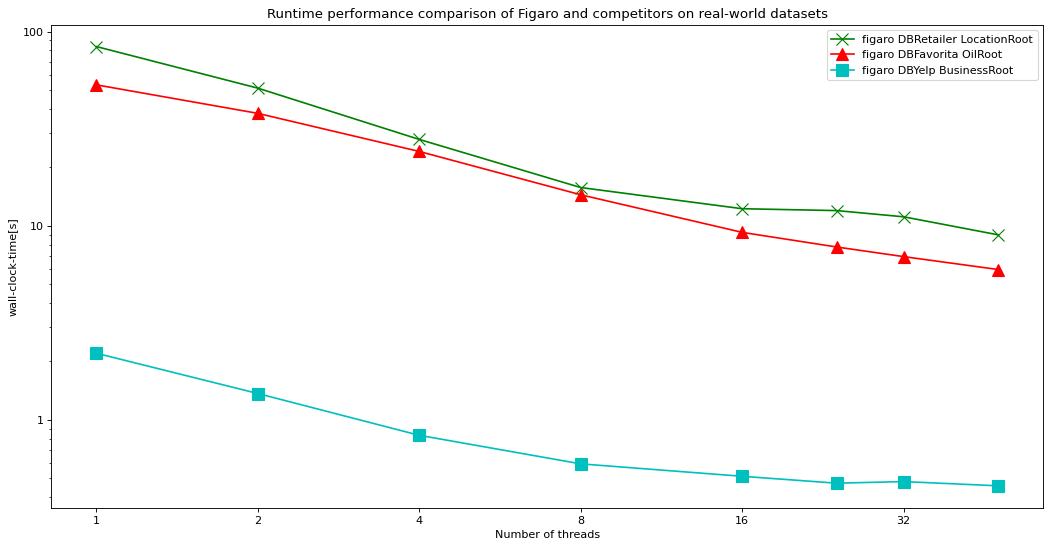

In [4]:
import matplotlib.pyplot as plt
from matplotlib import ticker


plt.figure("name", figsize=(16, 8), dpi=80)
plt.xlabel("Number of threads")
plt.ylabel("wall-clock-time[s]")

plt.title("Runtime performance comparison of Figaro and competitors on real-world datasets")


plt.yscale('log', base=10)
plt.xscale('log', base=2)
#plt.locator_params(axis='x', nbins=6)
#plt.locator_params(axis='y', nbins=20)
db_marker =  {"DBFavorita": "^", "DBYelp": "s", "DBRetailer": "x"}
db_colour =  {"DBFavorita": "r", "DBYelp": "c", "DBRetailer": "g"}
exp_colour = {"figaro": "r", "mkl": "b"}

for exp_name in exp_names:
    if exp_name == "mkl":
        continue
    for db_name in db_names:
        df_measurement = df_measurement_exp_dbs[(exp_name, db_name)]
        print(df_measurement)
        min_idx_cols = df_measurement.idxmin(axis="columns")
        max_num_threads = thread_nums_exp[exp_name][-1]
        min_join_order = min_idx_cols[max_num_threads]
        
        print(min_idx_cols[thread_nums_exp["figaro"][-1]])
        #for join_order in join_orders[db_name]:
        plt.plot(df_measurement[min_join_order], "-" + db_colour[db_name] + db_marker[db_name], label="{} {} {}".format(exp_name, db_name, min_join_order), markersize=10)

ax = plt.gca()
def myLogFormat(y,pos):
    # Find the number of decimal places required
    decimalplaces = int(np.maximum(-np.log10(y),0))     # =0 for numbers >=1
    # Insert that number into a format string
    formatstring = '{{:.{:1d}f}}'.format(decimalplaces)
    # Return the formatted tick label
    return formatstring.format(y)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))

#formatter = ticker.LogFormatter(base=10, labelOnlyBase=False)
#formatter.set_scientific(True) 
#formatter.set_powerlimits((-1,1)) 
#ax.yaxis.set_major_formatter(formatter) 

formatter = ticker.LogFormatter(base=2)
#formatter.set_scientific(True) 
#formatter.set_powerlimits((0,48)) 
ax.xaxis.set_major_formatter(formatter) 

plt.legend(loc="upper right")




plt.savefig("exp2threads.pdf",bbox_inches='tight')

plt.show()